In [1]:
import numpy as np
import pandas as pd
from os import walk, listdir
import random
from PIL import Image
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input, decode_predictions
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Activation, GlobalAveragePooling2D
from keras.metrics import AUC, Precision, Recall
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import json

In [2]:
base_path = './data/'
classes = listdir(base_path)

In [3]:
labels = {}
for index, row in enumerate(classes):
    labels[row] = index
labels

{'aerial_photography': 0,
 'ANIMAL': 1,
 'BUILDING': 2,
 'CLOTHING': 3,
 'long_exposure': 4,
 'MAN': 5,
 'milky_way': 6,
 'ocean': 7,
 'PERSON': 8,
 'PLANT': 9,
 'SKY': 10,
 'starry_sky': 11,
 'star_trail': 12,
 'TREE': 13,
 'VEHICLE': 14,
 'WOMAN': 15}

In [4]:
n_classes = len(classes)
def get_categorical(row):
    x = np.zeros(n_classes)
    x[row] = 1
    return x

In [5]:
def get_dataset():
    X = []
    y = []
    for k, v in labels.items():
        imgs = [base_path + k + '/' + x for x in listdir(base_path + k)]
        X.extend(imgs)
        y.extend([get_categorical(v)] * len(imgs))
    df = pd.DataFrame({'ImageID': X, 'LabelName': y})
    return df.sample(frac=1)

In [6]:
dataset = get_dataset()
dataset.head()

,ImageID,LabelName
3879,./data/CLOTHING/deba98dcd2e7fc73.jpg,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1635,./data/ANIMAL/a1ba35691f4f31b4.jpg,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15480,./data/WOMAN/bd82f0bfc3d39409.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7655,./data/ocean/ocean photography_732.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1174,./data/ANIMAL/23401142317a1115.jpg,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset['ImageID'], dataset['LabelName'], test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33)

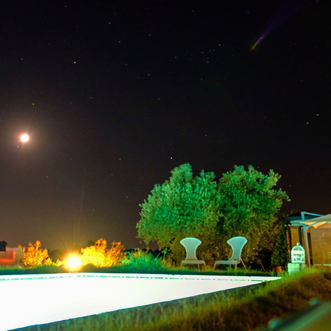

In [19]:
im = Image.open(X_train.iloc[4])
im = im.resize(size=(331,331))
display(im)

In [20]:
def get_images(X_label, y, augment = False):
    X = []
    Y = []
    for i, id in enumerate(X_label):
        im = Image.open(id)
        im = im.resize(size=(331,331))
        im = np.asarray(im)
        im_processed = preprocess_input(im)
        if im_processed.shape == (331, 331, 3):
            X.append(im_processed)
            if augment and random.random() > 0.33:
                im_flipped = np.fliplr(im_processed)
                im_noise = im_processed + np.random.normal(0, 0.05, im_processed.shape)
                X.append(im_flipped)
                X.append(im_noise)
                Y.append(y.iloc[i])
                Y.append(y.iloc[i])
            Y.append(y.iloc[i])
    return shuffle(np.array(X), np.array(Y), random_state=0)


In [21]:
base_model = NASNetLarge(weights='imagenet', include_top=True)

In [22]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [24]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(len(classes), activation='sigmoid'))

In [25]:
auc = AUC(multi_label=True, thresholds=[0.3])
precision = Precision(thresholds=[0.4])
recall = Recall(thresholds=[0.4])
def AUC_metric(y_true, y_pred):
    return auc(y_true, y_pred)

# def precision_metric(y_true, y_pred):
#     return precision(y_true, y_pred)

# def recall_metric(y_true, y_pred):
#     return recall(y_true, y_pred)

In [26]:
from sklearn.metrics import accuracy_score
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[AUC_metric])

In [27]:
batch_size = 256
validation_batch = 25
n_itr = int(np.ceil(len(X_train)/200))
for i in range(n_itr):
    print("Iteration", i + 1, "of", n_itr)
    X = X_train[i: i + batch_size]
    Y = y_train[i: i + batch_size]
    X, Y = get_images(X, Y, True)
    val_x, val_y = get_images(X_val[i: i + validation_batch], y_val[i: i + validation_batch])
    model.fit(X, Y, validation_data=(val_x, val_y))

Iteration 1 of 56
18/18 [==============================] - 161s 8s/step - loss: 0.6776 - AUC_metric: 0.4985 - val_loss: 0.6739 - val_AUC_metric: 0.5098
Iteration 2 of 56
18/18 [==============================] - 131s 7s/step - loss: 0.5168 - AUC_metric: 0.5161 - val_loss: 0.6593 - val_AUC_metric: 0.5209
Iteration 3 of 56
19/19 [==============================] - 135s 7s/step - loss: 0.3853 - AUC_metric: 0.5201 - val_loss: 0.6451 - val_AUC_metric: 0.5177
Iteration 4 of 56
19/19 [==============================] - 138s 7s/step - loss: 0.3117 - AUC_metric: 0.5191 - val_loss: 0.6320 - val_AUC_metric: 0.5206
Iteration 5 of 56
19/19 [==============================] - 133s 7s/step - loss: 0.2743 - AUC_metric: 0.5218 - val_loss: 0.6202 - val_AUC_metric: 0.5226
Iteration 6 of 56
19/19 [==============================] - 134s 7s/step - loss: 0.2491 - AUC_metric: 0.5250 - val_loss: 0.6109 - val_AUC_metric: 0.5257
Iteration 7 of 56
18/18 [==============================] - 134s 7s/step - loss: 0.2354 -

In [28]:
model.save('./model')
with open('model/labels.json', 'w+') as f:
    json.dump(labels, f)

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


In [29]:
X_test, Y_test = get_images(X_test, y_test)
loss, auc_score = model.evaluate(X_test, Y_test)
print(loss, auc_score)

97/97 [==============================] - 738s 8s/step - loss: 0.2157 - AUC_metric: 0.6923
0.21566545963287354 0.6922997832298279
